In [3]:
#Import required packages
import os

import numpy as np
import pandas as pd
import datetime as dt
import pandas_profiling
import re as re

import scipy.stats as stats
import matplotlib.pyplot as plt
%pylab inline
import seaborn as sns

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import sklearn.preprocessing as preprocess
import sklearn.feature_selection as feature_selection

import statsmodels as st
import statsmodels.formula.api as smp
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

Populating the interactive namespace from numpy and matplotlib


In [4]:
#Checking working directory
%pwd

'C:\\Users\\PHANI KUMAR\\Desktop\\Python Machine Learning\\2. Predicting House Prices'

In [5]:
house_price = pd.read_csv("House_Prices.csv")

In [6]:
house_price.head()

,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
0,1,114300,1790,2,2,2,No,East
1,2,114200,2030,4,2,3,No,East
2,3,114800,1740,3,2,1,No,East
3,4,94700,1980,3,2,3,No,East
4,5,119800,2130,3,3,3,No,East


In [7]:
#Dropped Home variable as it is unique column and csnt be used for analysis
house_price.drop("Home",axis = 1,inplace=True)

In [8]:
pandas_profile = pandas_profiling.ProfileReport(house_price)
pandas_profile

In [9]:
pandas_profile.to_file("pandas_profile.html")

In [10]:
#Splitting the data into categorical and continuous vars
cat_vars = ["Brick","Neighborhood"]
num_vars = ["Price","SqFt","Bedrooms","Bathrooms","Offers"]

In [11]:
data_cat = house_price[cat_vars]
data_num = house_price[num_vars]

In [12]:
#Outlier treatment
def outlier_capping(x):
    x = x.clip_upper(x.quantile(0.99))
    x = x.clip_lower(x.quantile(0.01))
    return x

data_num = data_num.apply(outlier_capping)

In [13]:
#Missing value imputation for categorical variables
def Missing_imputation(x):
    x = x.fillna(x.median())
    return x

data_num=data_num.apply(lambda x: Missing_imputation(x))

In [14]:
#Missing value imputation for categorical variables
def Cat_Missing_imputation(x):
    x = x.fillna(x.mode())
    return x
data_cat=data_cat.apply(lambda x: Cat_Missing_imputation(x))

In [15]:
data_final = pd.concat([data_num, data_cat], axis=1)

In [16]:
data_final = pd.get_dummies(data_final, ['Bricks','Neighborhood'], drop_first=True)

In [17]:
data_final.head()

,Price,SqFt,Bedrooms,Bathrooms,Offers,Bricks_Yes,Neighborhood_North,Neighborhood_West
0,114300,1790.0,2.0,2,2,0,0,0
1,114200,2030.0,4.0,2,3,0,0,0
2,114800,1740.0,3.0,2,1,0,0,0
3,94700,1980.0,3.0,2,3,0,0,0
4,119800,2130.0,3.0,3,3,0,0,0


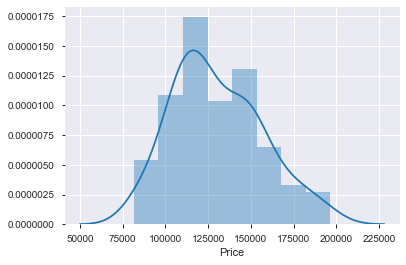

In [18]:
#The Y variable is normally distributed with a bell curve
sns.distplot(data_final.Price)

In [19]:
data_final.columns

Index(['Price', 'SqFt', 'Bedrooms', 'Bathrooms', 'Offers', 'Bricks_Yes',
       'Neighborhood_North', 'Neighborhood_West'],
      dtype='object')

In [20]:
#Feature Selection
features = data_final[data_final.columns.difference( ['Price'] )]
target = data_final['Price']

In [21]:
Final_list = ['SqFt', 'Bedrooms', 'Bathrooms', 'Offers', 'Bricks_Yes',
       'Neighborhood_North', 'Neighborhood_West'   
]
X=features[Final_list]

### As the number of variables is very low , instead of using algorithms to select variables, i have directly performed OLS regression and eliminated variables on the basis of their P- Values.

In [22]:
data_final1 = pd.concat([X,target],axis = 1)
data_final1.head()

,SqFt,Bedrooms,Bathrooms,Offers,Bricks_Yes,Neighborhood_North,Neighborhood_West,Price
0,1790.0,2.0,2,2,0,0,0,114300
1,2030.0,4.0,2,3,0,0,0,114200
2,1740.0,3.0,2,1,0,0,0,114800
3,1980.0,3.0,2,3,0,0,0,94700
4,2130.0,3.0,3,3,0,0,0,119800


In [23]:
#Split data into train and test
train, test = train_test_split(data_final1, test_size=0.3, random_state=1137)

In [24]:
"Price ~ "+"+".join(X.columns)

'Price ~ SqFt+Bedrooms+Bathrooms+Offers+Bricks_Yes+Neighborhood_North+Neighborhood_West'

In [25]:
#Removed variable neighborhood north as its p value is insignificant
equation = 'Price ~ SqFt+Bedrooms+Bathrooms+Offers+Bricks_Yes+Neighborhood_West'

In [26]:
ols_model = smp.ols(formula = equation,data = train)
ols_model_output = ols_model.fit()

In [27]:
print(ols_model_output.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     94.79
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           9.10e-35
Time:                        13:23:06   Log-Likelihood:                -941.79
No. Observations:                  89   AIC:                             1898.
Df Residuals:                      82   BIC:                             1915.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          2055.2744   1.02e+0

In [28]:
#Mathematical equation Price =  2055.2744+52.0589*SqFt+5117.9076*Bedrooms+
#9580.5087*Bathrooms+-9738.6450*Offers+14390*Bricks_Yes+19900*Neighborhood_West)

In [29]:
train_predicted = (ols_model_output.predict(train))
test_predicted = (ols_model_output.predict(test))

In [30]:
#Metrics (MAPE, RMSE, MSE, RMSPE)
train_actual = train.Price
test_actual = test.Price

In [31]:
train_RMSE = np.sqrt(np.mean(np.square(train_actual-train_predicted)))
test_RMSE  = np.sqrt(np.mean(np.square(test_actual-test_predicted)))

In [32]:
train_RMSE

9536.99866180585

In [33]:
test_RMSE

9572.530660135342

In [34]:
#Mean absolute percentage error
train_MAPE = np.mean(np.abs(train_actual-train_predicted)/train_actual)
test_MAPE  = np.mean(np.abs(test_actual-test_predicted)/test_actual)

In [35]:
train_MAPE

0.05913432956346305

In [36]:
test_MAPE

0.0662510989956815

In [37]:
train_RMSPE = np.sqrt(np.mean(np.square((train_actual-train_predicted)/train_actual)))
test_RMSPE  = np.sqrt(np.mean(np.square((test_actual-test_predicted)/test_actual)))

In [38]:
train_RMSPE

0.07448055145606107

In [39]:
test_RMSPE

0.08942463147382945

In [40]:
np.corrcoef(train_actual, train_predicted)

array([[1.        , 0.93487206],
       [0.93487206, 1.        ]])

In [41]:
np.corrcoef(test_actual, test_predicted)

array([[1.        , 0.92143642],
       [0.92143642, 1.        ]])

In [42]:
#Check
#Errors following normal distribution
#Errors should not have relationship with Y

train_errors = train_actual-train_predicted
test_errors = test_actual-test_predicted

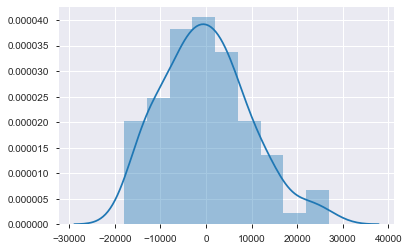

In [43]:
sns.distplot(train_errors)

In [44]:
np.corrcoef(train_actual, train_errors)

array([[1.        , 0.35498482],
       [0.35498482, 1.        ]])

In [45]:
#Decile analysis
train_results = pd.concat([train_actual, train_predicted], axis=1)
test_results = pd.concat([test_actual, test_predicted], axis=1)
train_results.columns = ['actual', 'pred']
test_results.columns = ['actual', 'pred']

In [46]:
train_results['Deciles']=pd.qcut(train_results['pred'],10, labels=False)
train_deciles = train_results.groupby(['Deciles']).apply(mean)[['actual','pred']]

In [47]:
test_results['Deciles']=pd.qcut(test_results['pred'],10, labels=False)
test_deciles = test_results.groupby(['Deciles']).apply(mean)[['actual','pred']]

In [48]:
train_deciles.to_excel("train deciles.xlsx")
test_deciles.to_excel("test deciles.xlsx")

In [49]:
from sklearn.externals import joblib
joblib.dump(ols_model_output, 'ols_model')

['ols_model']

In [50]:
#### Lets save everything in metrics_df to pickle object
import pickle

# now you can save it to a file
with open('model_ols.pkl', 'wb') as f:
    pickle.dump(ols_model_output, f)

In [51]:
# and later you can load it
with open('model_ols.pkl', 'rb') as f:
    model = pickle.load(f)

In [52]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     94.79
Date:                Mon, 23 Dec 2019   Prob (F-statistic):           9.10e-35
Time:                        13:23:10   Log-Likelihood:                -941.79
No. Observations:                  89   AIC:                             1898.
Df Residuals:                      82   BIC:                             1915.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          2055.2744   1.02e+0